In [1]:
import numpy as np
import tensorflow as tf

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform

import pydot
from IPython.display import SVG
import scipy.misc
from matplotlib.pyplot import imshow
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

import resnets_utils 

Using TensorFlow backend.


# 构建一个残差网络
在残差网络中，一个“捷径（shortcut）”或者说“跳跃连接（skip connection）”允许梯度直接反向传播到更浅的层，如下图：
<img src="images/20180509112530701.png" style="width:650px;height:200px;">

## 恒等块（Identity block）
恒等块是残差网络使用的的标准块，对应于输入的激活值（比如$a^{[l]}$）与输出激活值（比如$a^{[l+1]}$）具有相同的维度。
<img src="images/18.png" style="width:650px;height:200px;">
上图中，上面的曲线路径是“捷径”，下面的直线路径是主路径。在上图中，我们依旧把CONV2D 与 ReLU包含到了每个步骤中，为了提升训练的速度，我们在每一步也把数据进行了归一化（BatchNorm）

在实践中，我们要做一个更强大的版本：跳跃连接会跳过3个隐藏层而不是两个，就像下图： 
<img src="images/19.png" style="width:650px;height:200px;">
每个步骤如下：

主路径的第一部分：

- 第一个CONV2D有$F_1$个过滤器，其大小为（1，1），步长为（1，1），使用填充方式为“valid”，命名规则为`conv_name_base + '2a'`，使用0作为随机种子为其初始化。

- 第一个BatchNorm是通道的轴归一化，其命名规则为`bn_name_base + '2a'`。

- 接着使用ReLU激活函数，它没有命名也没有超参数。

主路径的第二部分：

- 第二个CONV2D有$F_2$个过滤器，其大小为$(f,f)$ ，步长为（1，1），使用填充方式为“same”，命名规则为 `conv_name_base + '2b'`，使用0作为随机种子为其初始化。

- 第二个BatchNorm是通道的轴归一化，其命名规则为`bn_name_base + '2b'`。

- 接着使用ReLU激活函数，它没有命名也没有超参数。

主路径的第三部分：

- 第三个CONV2D有$F_3$个过滤器，其大小为（1，1），步长为（1，1），使用填充方式为“valid”，命名规则为`conv_name_base + '2c'`，使用0作为随机种子为其初始化。

- 第三个BatchNorm是通道的轴归一化，其命名规则为`bn_name_base + '2c'`。

- 注意这里没有ReLU函数

最后一步：

- 将捷径与输入加在一起

- 使用ReLU激活函数，它没有命名也没有超参数。

接下来我们就要实现残差网络的恒等块了，请务必查看下面的中文手册：
- 实现Conv2D：[参见这里](https://keras.io/layers/convolutional/#conv2d)
- 实现BatchNorm: [参见这里](https://faroit.github.io/keras-docs/1.2.2/layers/normalization/) (axis: Integer, the axis that should be normalized (typically the channels axis))
- 实现激活:  `Activation('relu')(X)`
- 添加快捷方式传递的值: [参见这里](https://keras.io/layers/merge/#add)

In [2]:
def identity_block(X, f, filters, stage, block):
    """
    实现图3的恒等块

    参数：
        X - 输入的tensor类型的数据，维度为( m, n_H_prev, n_W_prev, n_H_prev )
        f - 整数，指定主路径中间的CONV窗口的维度
        filters - 整数列表，定义了主路径每层的卷积层的过滤器数量
        stage - 整数，根据每层的位置来命名每一层，与block参数一起使用。
        block - 字符串，据每层的位置来命名每一层，与stage参数一起使用。

    返回：
        X - 恒等块的输出，tensor类型，维度为(n_H, n_W, n_C)

    """

    #定义命名规则
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base   = "bn"  + str(stage) + block + "_branch"

    #获取过滤器
    F1, F2, F3 = filters

    #保存输入数据，将会用于为主路径添加捷径
    X_shortcut = X

    #主路径的第一部分
    ##卷积层
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1) ,padding="valid",
               name=conv_name_base+"2a", kernel_initializer=glorot_uniform(seed=0))(X)
    ##归一化
    X = BatchNormalization(axis=3,name=bn_name_base+"2a")(X)
    ##使用ReLU激活函数
    X = Activation("relu")(X)

    #主路径的第二部分
    ##卷积层
    X = Conv2D(filters=F2, kernel_size=(f,f),strides=(1,1), padding="same",
               name=conv_name_base+"2b", kernel_initializer=glorot_uniform(seed=0))(X)
    ##归一化
    X = BatchNormalization(axis=3,name=bn_name_base+"2b")(X)
    ##使用ReLU激活函数
    X = Activation("relu")(X)


    #主路径的第三部分
    ##卷积层
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding="valid",
               name=conv_name_base+"2c", kernel_initializer=glorot_uniform(seed=0))(X)
    ##归一化
    X = BatchNormalization(axis=3,name=bn_name_base+"2c")(X)
    ##没有ReLU激活函数

    #最后一步：
    ##将捷径与输入加在一起
    X = Add()([X,X_shortcut])
    ##使用ReLU激活函数
    X = Activation("relu")(X)

    return X

## 卷积块
我们已经实现了残差网络的恒等块，现在，残差网络的卷积块是另一种类型的残差块，它适用于输入输出的维度不一致的情况，它不同于上面的恒等块，与之区别在于，捷径中有一个CONV2D层，如下图：
<img src="images/20.png" style="width:650px;height:200px;">

捷径中的卷积层将把输入xx卷积为不同的维度，因此在主路径最后那里需要适配捷径中的维度。比如：把激活值中的宽高减少2倍，我们可以使用1x1的卷积，步伐为2。捷径上的卷积层不使用任何非线性激活函数，它的主要作用是仅仅应用（学习后的）线性函数来减少输入的维度，以便在后面的加法步骤中的维度相匹配。
每个步骤如下：

主路径的第一部分：

- 第一个CONV2D有$F_1$个过滤器，其大小为（1，1），步长为（s，s），使用填充方式为“valid”，命名规则为`conv_name_base + '2a'`，使用0作为随机种子为其初始化。

- 第一个BatchNorm是通道的轴归一化，其命名规则为`bn_name_base + '2a'`。

- 接着使用ReLU激活函数，它没有命名也没有超参数。

主路径的第二部分：

- 第二个CONV2D有$F_2$个过滤器，其大小为$(f,f)$ ，步长为（1，1），使用填充方式为“same”，命名规则为 `conv_name_base + '2b'`，使用0作为随机种子为其初始化。

- 第二个BatchNorm是通道的轴归一化，其命名规则为`bn_name_base + '2b'`。

- 接着使用ReLU激活函数，它没有命名也没有超参数。

主路径的第三部分：

- 第三个CONV2D有$F_3$个过滤器，其大小为（1，1），步长为（1，1），使用填充方式为“valid”，命名规则为`conv_name_base + '2c'`，使用0作为随机种子为其初始化。

- 第三个BatchNorm是通道的轴归一化，其命名规则为`bn_name_base + '2c'`。

- 注意这里没有ReLU函数

捷径：

- 此卷积层有$F_3$个过滤器，其维度为（1，1），步伐为（s，s），使用“valid”的填充方式，命名规则为`conv_name_base + '1'`

- 此规范层是通道的轴归一化，其命名规则为 `bn_name_base + '1'`

最后一步：

- 将捷径与输入加在一起

- 使用ReLU激活函数，它没有命名也没有超参数。

接下来我们就要实现残差网络的恒等块了，请务必查看下面的中文手册：
- 实现Conv2D：[参见这里](https://keras.io/layers/convolutional/#conv2d)
- 实现BatchNorm: [参见这里](https://faroit.github.io/keras-docs/1.2.2/layers/normalization/) (axis: Integer, the axis that should be normalized (typically the channels axis))
- 实现激活:  `Activation('relu')(X)`
- 添加快捷方式传递的值: [参见这里](https://keras.io/layers/merge/#add)

In [3]:
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    实现图5的卷积块

    参数：
        X - 输入的tensor类型的变量，维度为( m, n_H_prev, n_W_prev, n_C_prev)
        f - 整数，指定主路径中间的CONV窗口的维度
        filters - 整数列表，定义了主路径每层的卷积层的过滤器数量
        stage - 整数，根据每层的位置来命名每一层，与block参数一起使用。
        block - 字符串，据每层的位置来命名每一层，与stage参数一起使用。
        s - 整数，指定要使用的步幅

    返回：
        X - 卷积块的输出，tensor类型，维度为(n_H, n_W, n_C)
    """

    #定义命名规则
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base   = "bn"  + str(stage) + block + "_branch"

    #获取过滤器数量
    F1, F2, F3 = filters

    #保存输入数据
    X_shortcut = X

    #主路径
    ##主路径第一部分
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), padding="valid",
               name=conv_name_base+"2a", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2a")(X)
    X = Activation("relu")(X)

    ##主路径第二部分
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding="same",
               name=conv_name_base+"2b", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2b")(X)
    X = Activation("relu")(X)

    ##主路径第三部分
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding="valid",
               name=conv_name_base+"2c", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2c")(X)

    #捷径
    X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding="valid",
               name=conv_name_base+"1", kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3,name=bn_name_base+"1")(X_shortcut)

    #最后一步
    X = Add()([X,X_shortcut])
    X = Activation("relu")(X)

    return X

## 构建残差网络（50层）

我们已经做完所需要的所有残差块了，下面这个图就描述了神经网络的算法细节，图中的”ID BLOCK“是指标准的恒等块，”ID BLOCK X3“是指把三个恒等块放在一起。 
<img src="images/21.png" style="width:650px;height:200px;">

这个50层的网络的细节如下: 
- 对输入数据进行0填充，padding =（3,3）

- stage1：

    - 卷积层有64个过滤器，其维度为（7，7），步伐为（2，2），命名为“conv1”

    - 规范层（BatchNorm）对输入数据进行通道轴归一化。

    - 最大值池化层使用一个（3，3）的窗口和（2，2）的步伐。

- stage2：

    - 卷积块使用f=3个大小为[64，64，256]的过滤器，f=3，s=1,block=”a”

    - 2个恒等块使用三个大小为[64，64，256]的过滤器，f=3，block=”b”、”c”

- stage3：

    - 卷积块使用f=3个大小为[128,128,512]的过滤器，f=3，s=2,block=”a”

    - 3个恒等块使用三个大小为[128,128,512]的过滤器，f=3，block=”b”、”c”、”d”

- stage4：

    - 卷积块使用f=3个大小为[256,256,1024]的过滤器，f=3，s=2,block=”a”

    - 5个恒等块使用三个大小为[256,256,1024]的过滤器，f=3，block=”b”、”c”、”d”、”e”、”f”

- stage5：

    - 卷积块使用f=3个大小为[512,512,2048]的过滤器，f=3，s=2,block=”a”

    - 2个恒等块使用三个大小为[256,256,2048]的过滤器，f=3，block=”b”、”c”

- 均值池化层使用维度为（2,2）的窗口，命名为“avg_pool”

- 展开操作没有任何超参数以及命名
- 全连接层（密集连接）使用softmax激活函数，命名为"fc" + str(classes)

为了实现这50层的残差网络，我们需要查看一下手册：

- 均值池化层：[参见这里](https://keras.io/layers/pooling/#averagepooling2d)

- Conv2D： [参见这里](https://keras.io/layers/convolutional/#conv2d)
- BatchNorm:  [参见这里](https://keras.io/layers/normalization/#batchnormalization) (axis: Integer, the axis that should be normalized (typically the features axis))

- 0填充：[参见这里](https://keras.io/layers/convolutional/#zeropadding2d)

- 最大值池化层： [参见这里](https://keras.io/layers/pooling/#maxpooling2d)

- 全连接层： [参见这里](https://keras.io/layers/core/#dense)

- 添加快捷方式传递的值：[参见这里](https://keras.io/layers/merge/#add)

In [4]:
def ResNet50(input_shape=(64,64,3),classes=6):
    """
    实现ResNet50
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    参数：
        input_shape - 图像数据集的维度
        classes - 整数，分类数

    返回：
        model - Keras框架的模型

    """

    #定义tensor类型的输入数据
    X_input = Input(input_shape)

    #0填充
    X = ZeroPadding2D((3,3))(X_input)

    #stage1
    X = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), name="conv1",
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name="bn_conv1")(X)
    X = Activation("relu")(X)
    X = MaxPooling2D(pool_size=(3,3), strides=(2,2))(X)

    #stage2
    X = convolutional_block(X, f=3, filters=[64,64,256], stage=2, block="a", s=1)
    X = identity_block(X, f=3, filters=[64,64,256], stage=2, block="b")
    X = identity_block(X, f=3, filters=[64,64,256], stage=2, block="c")

    #stage3
    X = convolutional_block(X, f=3, filters=[128,128,512], stage=3, block="a", s=2)
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block="b")
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block="c")
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block="d")

    #stage4
    X = convolutional_block(X, f=3, filters=[256,256,1024], stage=4, block="a", s=2)
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="b")
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="c")
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="d")
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="e")
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="f")

    #stage5
    X = convolutional_block(X, f=3, filters=[512,512,2048], stage=5, block="a", s=2)
    X = identity_block(X, f=3, filters=[512,512,2048], stage=5, block="b")
    X = identity_block(X, f=3, filters=[512,512,2048], stage=5, block="c")

    #均值池化层
    X = AveragePooling2D(pool_size=(2,2),padding="same")(X)

    #输出层
    X = Flatten()(X)
    X = Dense(classes, activation="softmax", name="fc"+str(classes),
              kernel_initializer=glorot_uniform(seed=0))(X)


    #创建模型
    model = Model(inputs=X_input, outputs=X, name="ResNet50")

    return model

In [5]:
#对模型做实体化和编译工作：
model = ResNet50(input_shape=(64,64,3),classes=6)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

<img src="images/22.png" style="width:650px;height:200px;">

In [6]:
#加载数据
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = resnets_utils.load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = resnets_utils.convert_to_one_hot(Y_train_orig, 6).T
Y_test = resnets_utils.convert_to_one_hot(Y_test_orig, 6).T

print("number of training examples = " + str(X_train.shape[0]))
print("number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [25]:
model.fit(X_train,Y_train,epochs=100,batch_size=64)

Epoch 1/100
1080/1080 [==============================] - 266s 247ms/step - loss: 0.7320 - acc: 0.8519
Epoch 2/100
1080/1080 [==============================] - 265s 245ms/step - loss: 0.4354 - acc: 0.9278
Epoch 3/100
1080/1080 [==============================] - 269s 249ms/step - loss: 0.3456 - acc: 0.9704
Epoch 4/100
1080/1080 [==============================] - 287s 266ms/step - loss: 0.4127 - acc: 0.9657
Epoch 5/100
1080/1080 [==============================] - 269s 249ms/step - loss: 0.4008 - acc: 0.9565
Epoch 6/100
1080/1080 [==============================] - 269s 249ms/step - loss: 0.3688 - acc: 0.9602
Epoch 7/100
1080/1080 [==============================] - 269s 249ms/step - loss: 0.2731 - acc: 0.9713
Epoch 8/100
1080/1080 [==============================] - 269s 249ms/step - loss: 0.2735 - acc: 0.9537
Epoch 9/100
1080/1080 [==============================] - 269s 249ms/step - loss: 0.3311 - acc: 0.9259
Epoch 10/100
1080/1080 [==============================] - 269s 249ms/step - loss: 

In [35]:
model.save('res.h5')

In [ ]:
model = load_model("Res.h5") 

In [26]:
preds = model.evaluate(X_test,Y_test)
print("误差值 = " + str(preds[0]))
print("准确率 = " + str(preds[1]))

120/120 [==============================] - 78s 650ms/step
误差值 = 0.12439964612325033
准确率 = 0.949999996026357


[[9.9931860e-01 7.0890437e-08 2.0107608e-04 4.7210135e-04 7.8064013e-06
  2.5613858e-07]]


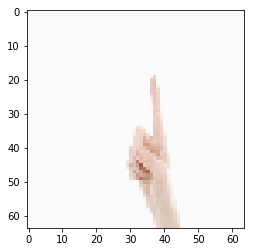

In [7]:
#测试自己的图片
img_path = 'finger.jpg'

img = image.load_img(img_path, target_size=(64, 64))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(model.predict(x))

In [8]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.